# Outlier Analysis Final Notebook!

First we want to load the data and make sure we have no issues!

In [27]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from scipy.stats import zscore

df = pd.read_csv('Mega_merged_all_real_values.csv')
df.head()

/var/folders/h7/9xqmfqgd45b8j4np0nndf6gw0000gn/T/ipykernel_40582/2268875318.py:8: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Mega_merged_all_real_values.csv')


,account_id,account_name,incorporated_country,ticker,Evaluation_status,Scope_3_emissions_type,Scope_3_emissions_amount,Symbol_1,Year,Market_Cap,...,grossProfit_USD,netIncome_USD,cashAndCashEquivalents_USD,shortTermInvestments_USD,longTermInvestments_USD,totalAssets_USD,totalLiabilities_USD,totalInvestments_USD,totalDebt_USD,totalEquity_USD
0,44,3i Group,United Kingdom,III LN,"Relevant, calculated",Waste generated in operations,12.34,III.L,2013,3.654278e+09,...,938530000.0,656590000.0,816610000.0,0.0,4.460240e+09,5.572760e+09,1.371600e+09,4.460240e+09,1.078230e+09,4.201160e+09
1,44,3i Group,United Kingdom,III LN,"Relevant, calculated",Business travel,56.78,III.L,2013,3.654278e+09,...,938530000.0,656590000.0,816610000.0,0.0,4.460240e+09,5.572760e+09,1.371600e+09,4.460240e+09,1.078230e+09,4.201160e+09
2,53,Abertis Infraestructuras,Spain,ABE SM,"Relevant, calculated",Purchased goods and services,53635.12,ABE.MC,2013,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,53,Abertis Infraestructuras,Spain,ABE SM,"Relevant, calculated",Waste generated in operations,2518.18,ABE.MC,2013,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,53,Abertis Infraestructuras,Spain,ABE SM,"Relevant, calculated",Business travel,913.42,ABE.MC,2013,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
df["Primary activity"].nunique()

214

### Here we are looking at each primary activity, every single year, "Automobiles in 2014" as example, then finding the median emission amount within that year & activity, then we calculate the z-score and remove instances where the z-score is higher than 2.5!

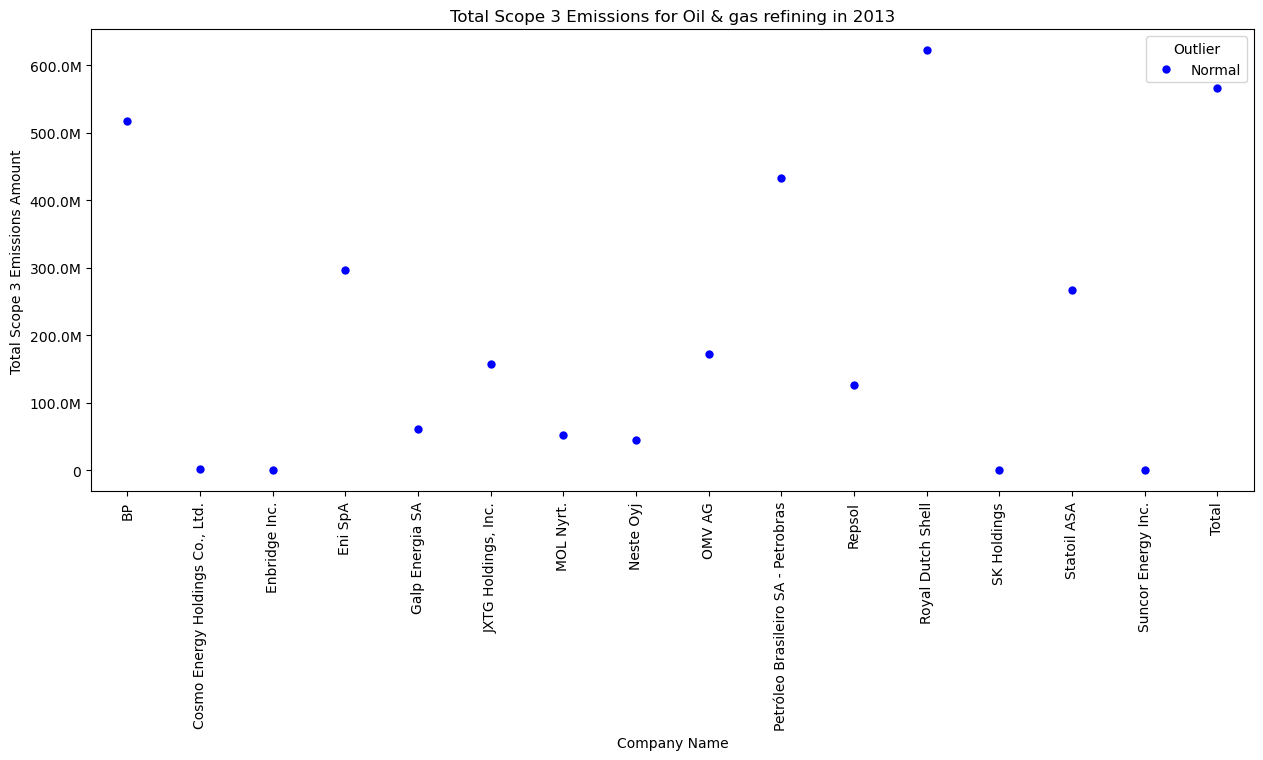

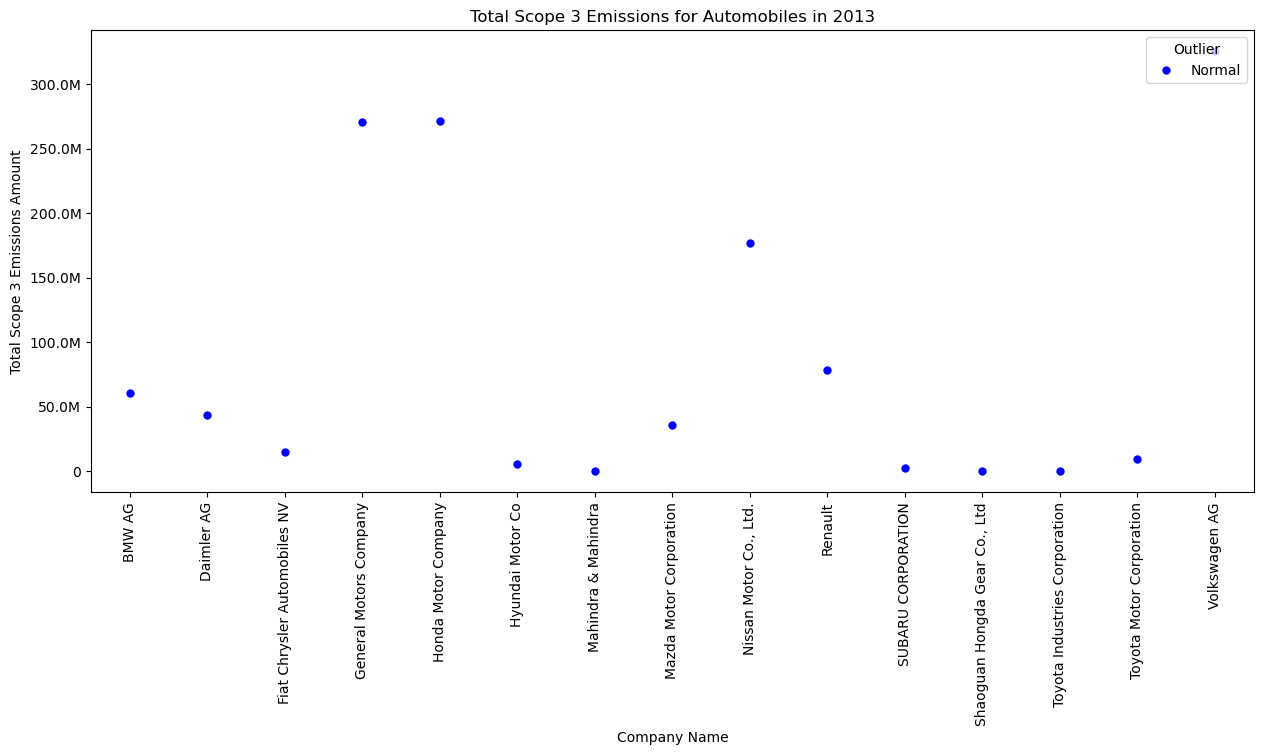

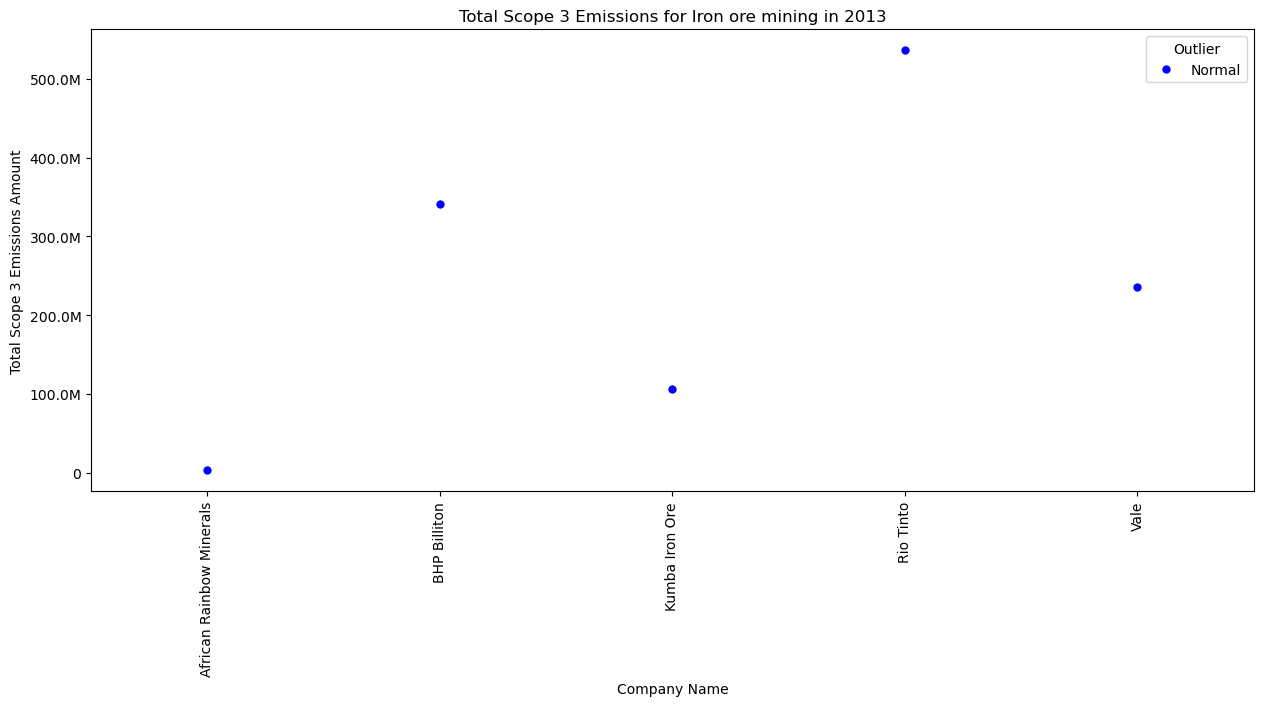

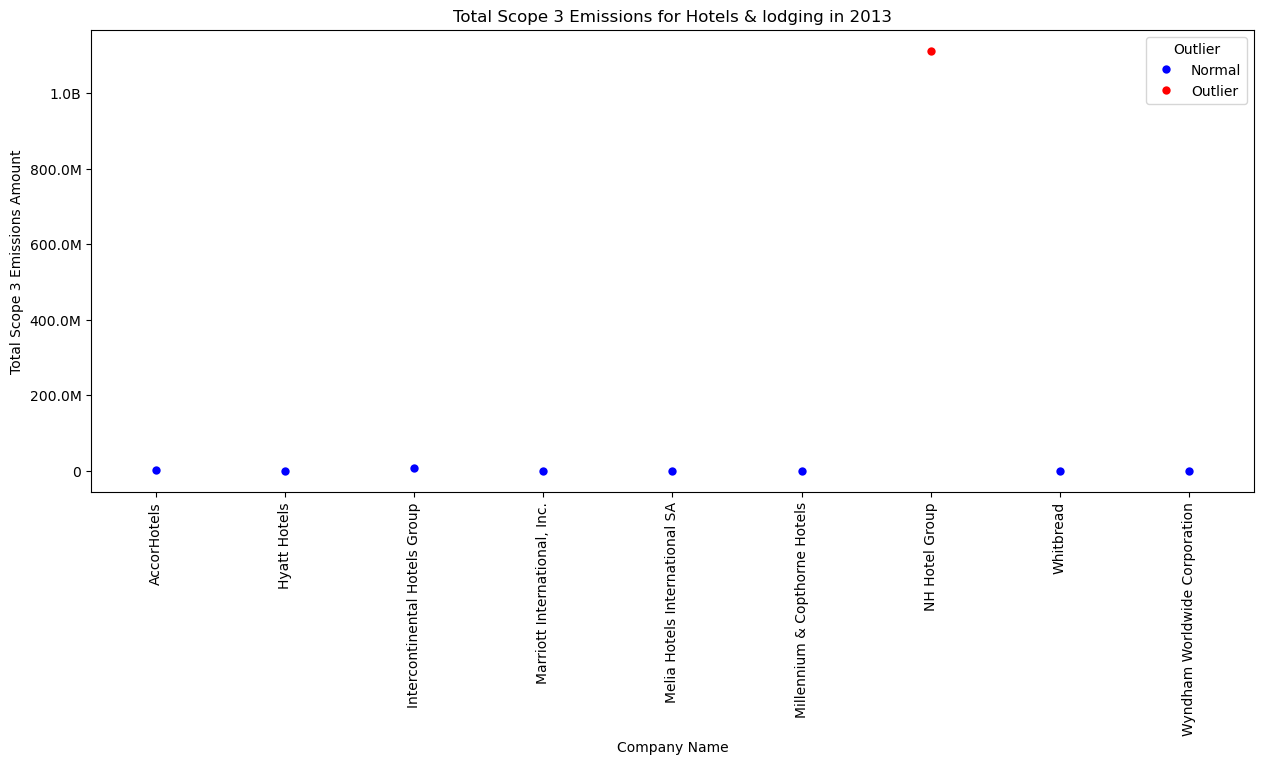

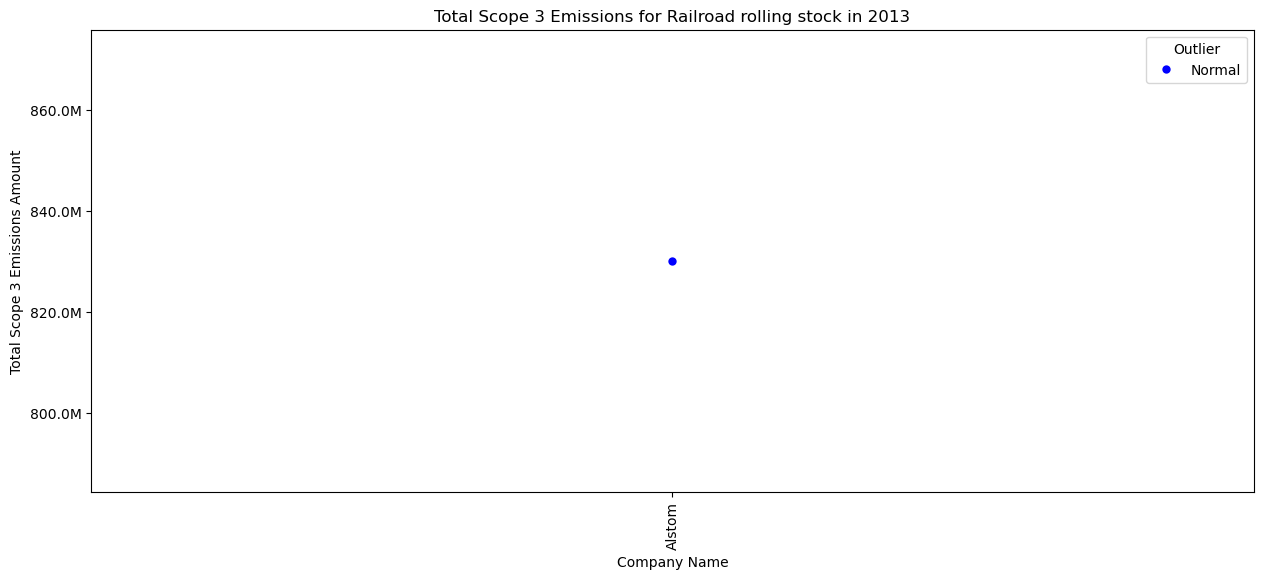

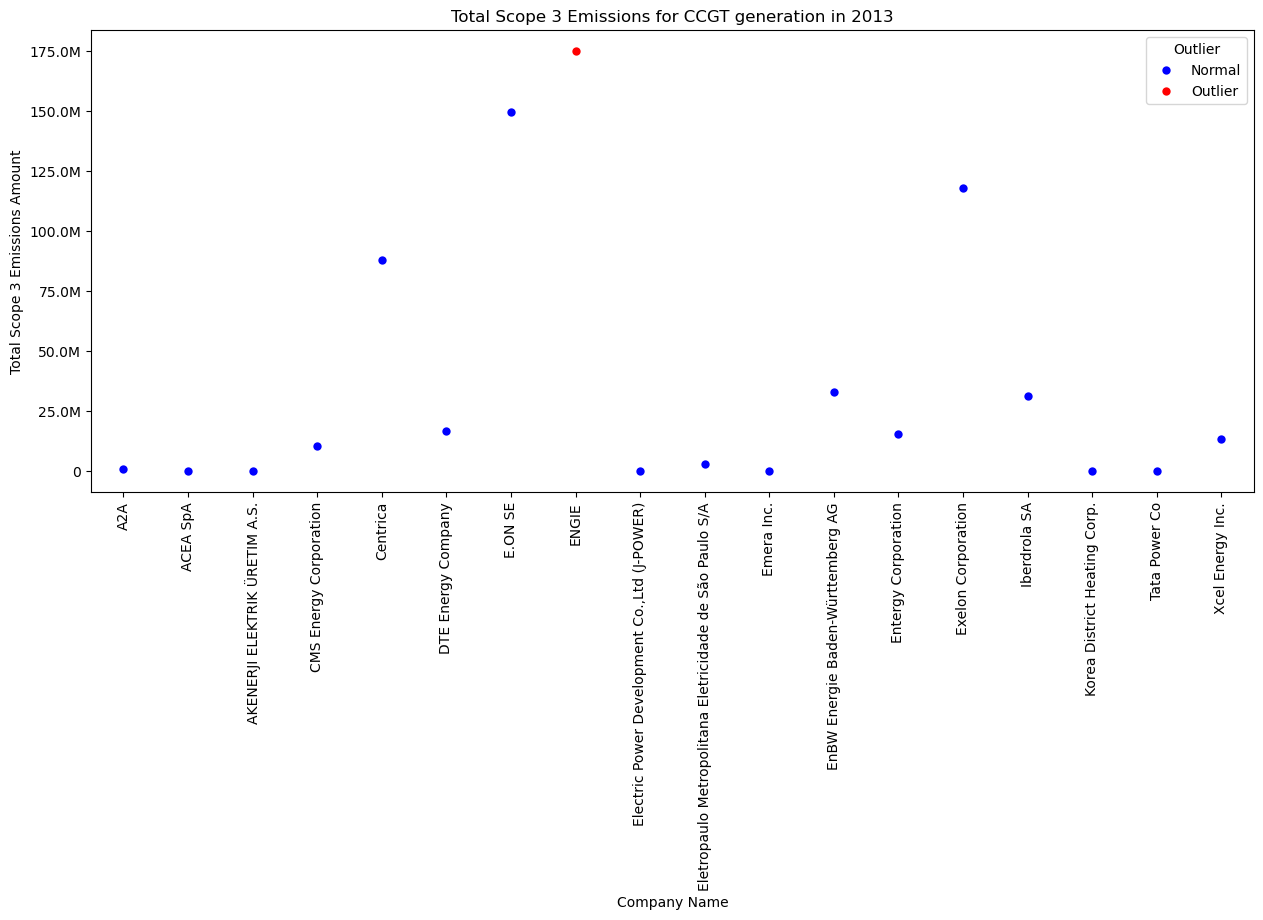

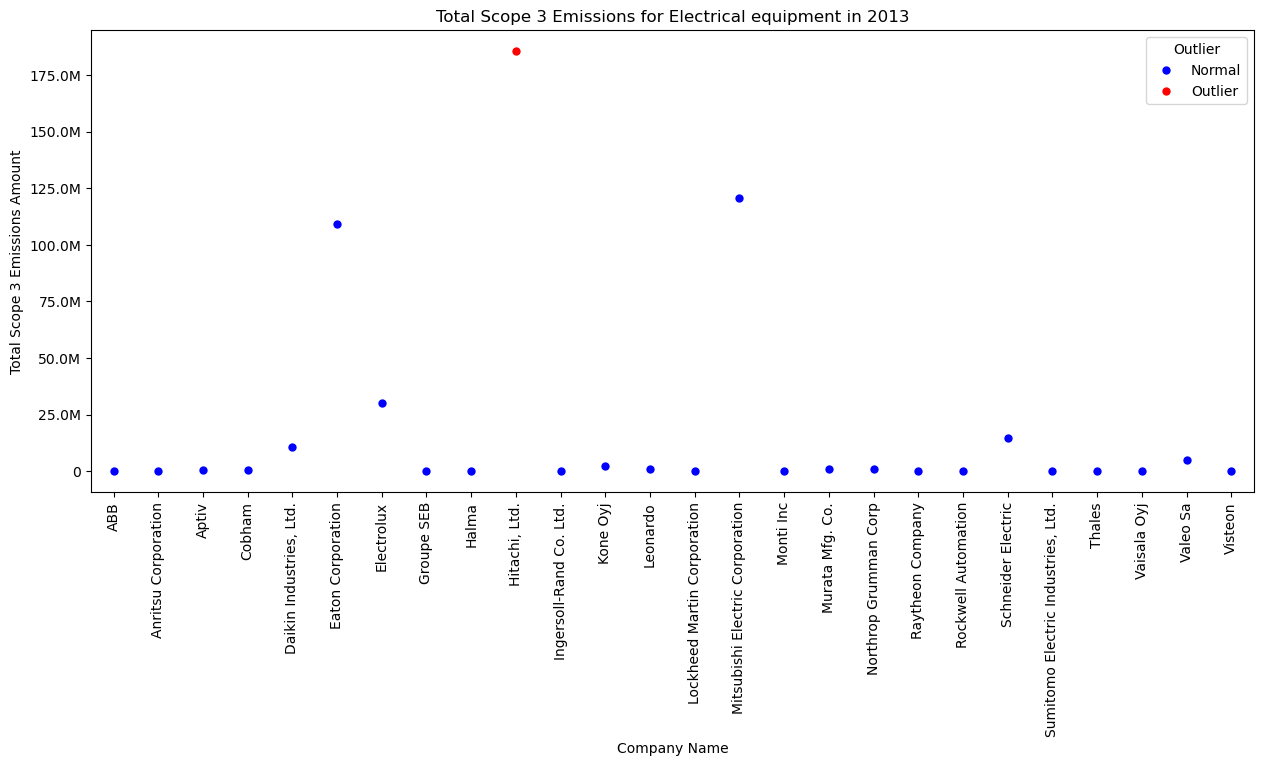

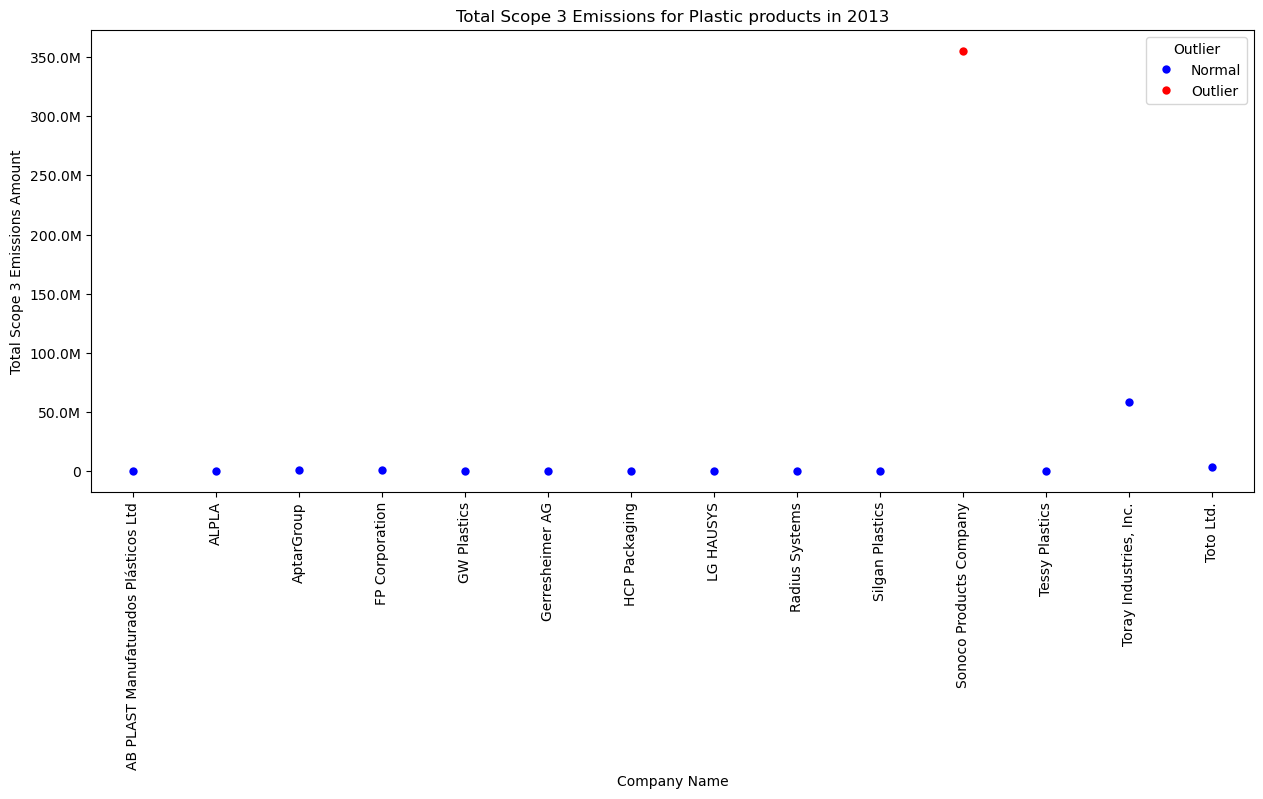

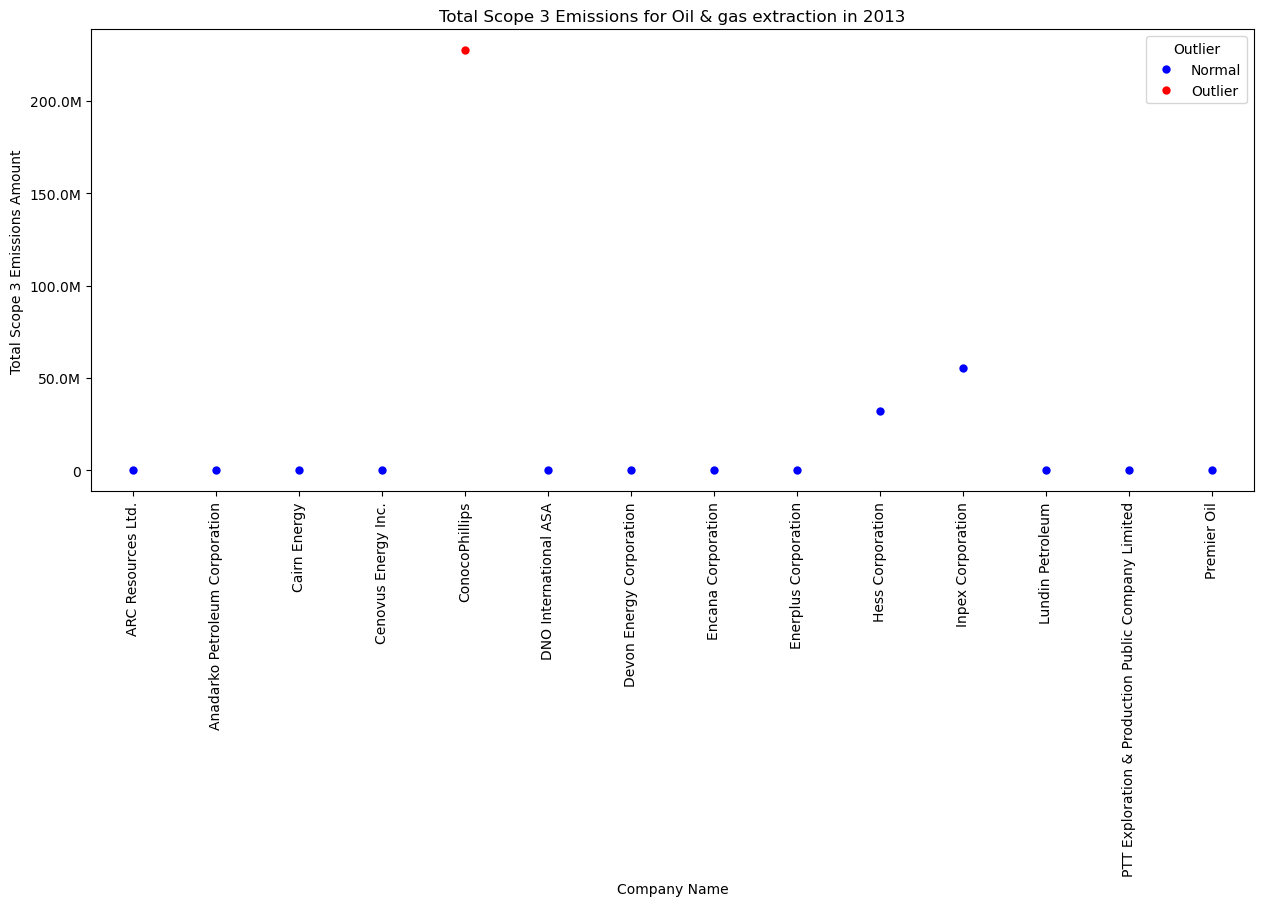

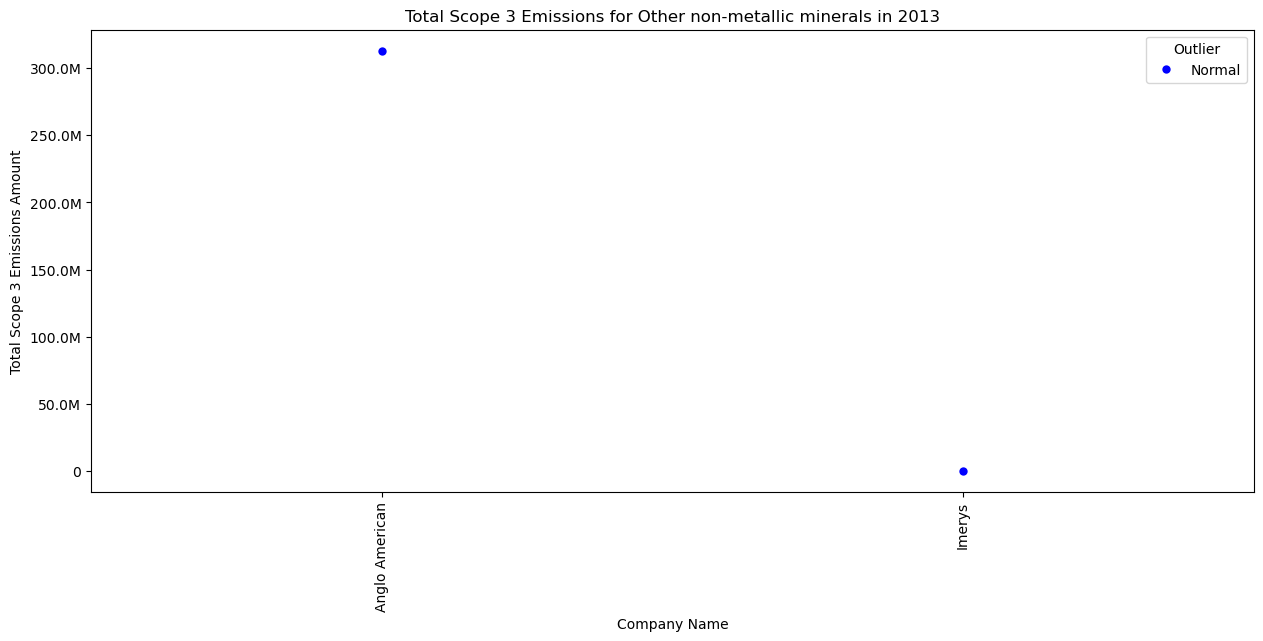

In [6]:
# Get the earliest year from 2013 onwards
years = sorted(df[df["Year"] >= 2013]["Year"].unique())
earliest_year = min(years)

# Filter data for the earliest year
yearly_df = df[df["Year"] == earliest_year]

# Identify top 10 primary activities by total Scope 3 emissions
top_activities = (
    yearly_df.groupby("Primary activity")["Scope_3_emissions_amount"]
    .sum()
    .nlargest(10)
    .index
)

# Filter data for the selected top activities
filtered_df = yearly_df[yearly_df["Primary activity"].isin(top_activities)]

# Create a directory to save plots
output_dir = "scope3_emissions_top10"
os.makedirs(output_dir, exist_ok=True)

# Initialize list to store outliers
outliers_list = []

# Generate and save plots for each primary activity
for primary_activity in top_activities:
    activity_df = filtered_df[filtered_df["Primary activity"] == primary_activity]

    if activity_df.empty:
        continue

    # Aggregate emissions by company (sum of Scope 3 emission amount)
    aggregated_df = activity_df.groupby("account_name")["Scope_3_emissions_amount"].sum().reset_index()

    # Calculate Z-scores for emissions within this Primary Activity
    aggregated_df["z_score"] = zscore(aggregated_df["Scope_3_emissions_amount"], nan_policy='omit')

    # Identify outliers (Z-score > 2.5)
    aggregated_df["outlier"] = aggregated_df["z_score"].abs() > 2.5

    # Extract outliers and store them
    outliers = aggregated_df[aggregated_df["outlier"]][["account_name", "Scope_3_emissions_amount", "z_score"]]
    outliers["Primary activity"] = primary_activity
    outliers_list.append(outliers)

    # Convert outlier column to string for visualization
    aggregated_df["outlier"] = aggregated_df["outlier"].astype(str)

    # Create scatter plot
    plt.figure(figsize=(15, 6))
    ax = sns.stripplot(
        x="account_name", 
        y="Scope_3_emissions_amount", 
        data=aggregated_df, 
        jitter=True, 
        size=6, 
        hue="outlier", 
        palette={"True": "red", "False": "blue"} 
    )

    plt.xticks(rotation=90)
    plt.xlabel("Company Name")
    plt.ylabel("Total Scope 3 Emissions Amount")
    plt.title(f"Total Scope 3 Emissions for {primary_activity} in {earliest_year}")

    # Format y-axis
    def human_format(num, pos):
        if num >= 1_000_000_000:
            return f'{num / 1_000_000_000:.1f}B'
        elif num >= 1_000_000:
            return f'{num / 1_000_000:.1f}M'
        else:
            return f'{num:.0f}'

    ax.yaxis.set_major_formatter(ticker.FuncFormatter(human_format))

    # Adjust legend
    handles, labels = ax.get_legend_handles_labels()
    legend_labels = {"False": "Normal", "True": "Outlier"}
    plt.legend(handles, [legend_labels[label] for label in labels], title="Outlier", loc="upper right")

    # Save plot
    filename = f"{primary_activity.replace(',', '').replace(' ', '_')}_{earliest_year}.png"
    file_path = os.path.join(output_dir, filename)
    plt.savefig(file_path, bbox_inches='tight')
    plt.show()

# Combine all outliers into a single dataframe
outliers_df = pd.concat(outliers_list, ignore_index=True)

# Save the outliers to a CSV file
# outliers_csv_path = os.path.join(output_dir, "outliers_scope3_emissions.csv")
# outliers_df.to_csv(outliers_csv_path, index=False)

# print(f"Outliers saved to: {outliers_csv_path}")

### Here we are looking at each primary activity, every single year, "Automobiles in 2014" as example, then finding the median emission amount within that year & activity, then we calculate the z-score and remove instances where the z-score is higher than 2.5!

In [7]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from scipy.stats import zscore

# Load the dataset
file_path = "Mega_merged_all_real_values.csv"  # Update with your correct path
df = pd.read_csv(file_path)

# Get unique years from 2013 onwards
years = sorted(df[df["Year"] >= 2013]["Year"].unique())

# Create a base directory to store all results
base_output_dir = "scope3_emissions_analysis"
os.makedirs(base_output_dir, exist_ok=True)

# Iterate through each year
for year in years:
    print(f"Processing year: {year}")

    # Filter dataset for the given year
    yearly_df = df[df["Year"] == year]

    # Get a list of all primary activities for that year
    primary_activities_for_year = yearly_df["Primary activity"].dropna().unique()

    # Process activities in batches of 10
    batch_size = 10
    for i in range(0, len(primary_activities_for_year), batch_size):
        batch_activities = primary_activities_for_year[i:i + batch_size]

        # Create a directory for this year
        year_output_dir = os.path.join(base_output_dir, f"{year}")
        os.makedirs(year_output_dir, exist_ok=True)

        # Filter data for the selected batch of activities
        filtered_df = yearly_df[yearly_df["Primary activity"].isin(batch_activities)]

        # Initialize a list to store detected outliers
        outliers_list = []

        # Process each activity in the batch
        for primary_activity in batch_activities:
            activity_df = filtered_df[filtered_df["Primary activity"] == primary_activity]

            if activity_df.empty:
                continue

            # Aggregate emissions by company (sum of Scope 3 emission amount)
            aggregated_df = activity_df.groupby("account_name")["Scope_3_emissions_amount"].sum().reset_index()

            # Calculate Z-scores for emissions within this Primary Activity
            aggregated_df["z_score"] = zscore(aggregated_df["Scope_3_emissions_amount"], nan_policy='omit')

            # Identify outliers (Z-score > 2.5)
            aggregated_df["outlier"] = aggregated_df["z_score"].abs() > 2.5

            # Extract outliers and store them
            outliers = aggregated_df[aggregated_df["outlier"]][["account_name", "Scope_3_emissions_amount", "z_score"]]
            outliers["Primary activity"] = primary_activity
            outliers["Year"] = year
            outliers_list.append(outliers)

            # Convert outlier column to string for visualization
            aggregated_df["outlier"] = aggregated_df["outlier"].astype(str)

            # Create scatter plot
            plt.figure(figsize=(15, 6))
            ax = sns.stripplot(
                x="account_name", 
                y="Scope_3_emissions_amount", 
                data=aggregated_df, 
                jitter=True, 
                size=6, 
                hue="outlier", 
                palette={"True": "red", "False": "blue"} 
            )

            plt.xticks(rotation=90)
            plt.xlabel("Company Name")
            plt.ylabel("Total Scope 3 Emissions Amount")
            plt.title(f"Total Scope 3 Emissions for {primary_activity} in {year}")

            # Format y-axis
            def human_format(num, pos):
                if num >= 1_000_000_000:
                    return f'{num / 1_000_000_000:.1f}B'
                elif num >= 1_000_000:
                    return f'{num / 1_000_000:.1f}M'
                else:
                    return f'{num:.0f}'

            ax.yaxis.set_major_formatter(ticker.FuncFormatter(human_format))

            # Adjust legend
            handles, labels = ax.get_legend_handles_labels()
            legend_labels = {"False": "Normal", "True": "Outlier"}
            plt.legend(handles, [legend_labels[label] for label in labels], title="Outlier", loc="upper right")

            # Save plot
            filename = f"{primary_activity.replace(',', '').replace(' ', '_')}_{year}.png"
            file_path = os.path.join(year_output_dir, filename)
            plt.savefig(file_path, bbox_inches='tight')
            plt.close()

        # Combine all outliers into a single dataframe
        if outliers_list:
            outliers_df = pd.concat(outliers_list, ignore_index=True)

            # Save outliers to a CSV file for the batch
            outliers_csv_path = os.path.join(year_output_dir, f"outliers_batch_{i // batch_size + 1}.csv")
            outliers_df.to_csv(outliers_csv_path, index=False)

            print(f"Saved outliers for batch {i // batch_size + 1} in year {year} to {outliers_csv_path}")

print("Processing complete. All plots and outliers have been saved.")

/var/folders/h7/9xqmfqgd45b8j4np0nndf6gw0000gn/T/ipykernel_40582/3709157159.py:10: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Processing year: 2013
Saved outliers for batch 1 in year 2013 to scope3_emissions_analysis/2013/outliers_batch_1.csv
Saved outliers for batch 2 in year 2013 to scope3_emissions_analysis/2013/outliers_batch_2.csv
Saved outliers for batch 3 in year 2013 to scope3_emissions_analysis/2013/outliers_batch_3.csv
Saved outliers for batch 4 in year 2013 to scope3_emissions_analysis/2013/outliers_batch_4.csv
Saved outliers for batch 5 in year 2013 to scope3_emissions_analysis/2013/outliers_batch_5.csv
Saved outliers for batch 6 in year 2013 to scope3_emissions_analysis/2013/outliers_batch_6.csv
Saved outliers for batch 7 in year 2013 to scope3_emissions_analysis/2013/outliers_batch_7.csv
Saved outliers for batch 8 in year 2013 to scope3_emissions_analysis/2013/outliers_batch_8.csv
Saved outliers for batch 9 in year 2013 to scope3_emissions_analysis/2013/outliers_batch_9.csv
Saved outliers for batch 10 in year 2013 to scope3_emissions_analysis/2013/outliers_batch_10.csv
Saved outliers for batch 1

/var/folders/h7/9xqmfqgd45b8j4np0nndf6gw0000gn/T/ipykernel_40582/3709157159.py:105: UserWarning: Glyph 65381 (\N{HALFWIDTH KATAKANA MIDDLE DOT}) missing from font(s) DejaVu Sans.
  plt.savefig(file_path, bbox_inches='tight')


Saved outliers for batch 6 in year 2023 to scope3_emissions_analysis/2023/outliers_batch_6.csv
Saved outliers for batch 7 in year 2023 to scope3_emissions_analysis/2023/outliers_batch_7.csv
Saved outliers for batch 8 in year 2023 to scope3_emissions_analysis/2023/outliers_batch_8.csv
Saved outliers for batch 9 in year 2023 to scope3_emissions_analysis/2023/outliers_batch_9.csv
Saved outliers for batch 10 in year 2023 to scope3_emissions_analysis/2023/outliers_batch_10.csv
Saved outliers for batch 11 in year 2023 to scope3_emissions_analysis/2023/outliers_batch_11.csv
Saved outliers for batch 12 in year 2023 to scope3_emissions_analysis/2023/outliers_batch_12.csv
Saved outliers for batch 13 in year 2023 to scope3_emissions_analysis/2023/outliers_batch_13.csv
Saved outliers for batch 14 in year 2023 to scope3_emissions_analysis/2023/outliers_batch_14.csv
Saved outliers for batch 15 in year 2023 to scope3_emissions_analysis/2023/outliers_batch_15.csv
Saved outliers for batch 16 in year 20

### Now I want to merge the outliers to one file!

In [9]:
import pandas as pd
import os

# Define base directory where all yearly data is stored
base_output_dir = "scope3_emissions_analysis"

# Create an empty list to collect all outlier data
all_outliers = []

# Iterate through each year's folder
for year in sorted(os.listdir(base_output_dir)):
    year_path = os.path.join(base_output_dir, year)
    
    if os.path.isdir(year_path):
        # Find all outlier CSV files in this year's folder
        for file in os.listdir(year_path):
            if file.startswith("outliers_batch") and file.endswith(".csv"):
                file_path = os.path.join(year_path, file)
                
                # Read and append the outlier data
                df = pd.read_csv(file_path)
                all_outliers.append(df)

# Combine all outlier data into one final DataFrame
final_outliers_df = pd.concat(all_outliers, ignore_index=True)

# Save the final combined outlier dataset
final_outliers_path = os.path.join(base_output_dir, "all_outliers_combined.csv")
final_outliers_df.to_csv(final_outliers_path, index=False)

print(f"All outliers combined and saved to: {final_outliers_path}")

All outliers combined and saved to: scope3_emissions_analysis/all_outliers_combined.csv


/var/folders/h7/9xqmfqgd45b8j4np0nndf6gw0000gn/T/ipykernel_40582/2509516000.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_outliers_df = pd.concat(all_outliers, ignore_index=True)


In [10]:
data = pd.read_csv('all_outliers_combined.csv')
data.head()

,account_name,Scope_3_emissions_amount,z_score,Primary activity,Year
0,Rolls-Royce,120077646.0,2.643862,Engines & motors,2013
1,Deutsche Post AG,32350000.0,2.545231,Logistics - 3rd party,2013
2,Samsung Electronics,40537152.0,2.712925,Communications equipment,2013
3,LEGRAND,1678575.0,3.252330,Fabricated metal components,2013
4,Mirvac Group,42553.0,2.711946,Real estate owners & developers,2013


### We found that in our data we are having issues with the account_name column, companies appearing more than once under different names, so we have to make sure we have the account_id displayed next to it!

In [11]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from scipy.stats import zscore

# Load the dataset
file_path = "Mega_merged_all_real_values.csv"  # Update with the correct path
df = pd.read_csv(file_path)

# Get unique years from 2013 onwards
years = sorted(df[df["Year"] >= 2013]["Year"].unique())

# Create a new base directory for storing results
base_output_dir = "scope3_emissions_analysis2"  # Updated directory name
os.makedirs(base_output_dir, exist_ok=True)

# Iterate through each year
for year in years:
    print(f"Processing year: {year}")

    # Filter dataset for the given year
    yearly_df = df[df["Year"] == year]

    # Get a list of all primary activities for that year
    primary_activities_for_year = yearly_df["Primary activity"].dropna().unique()

    # Process activities in batches of 10
    batch_size = 10
    for i in range(0, len(primary_activities_for_year), batch_size):
        batch_activities = primary_activities_for_year[i:i + batch_size]

        # Create a directory for this year
        year_output_dir = os.path.join(base_output_dir, f"{year}")
        os.makedirs(year_output_dir, exist_ok=True)

        # Filter data for the selected batch of activities
        filtered_df = yearly_df[yearly_df["Primary activity"].isin(batch_activities)]

        # Initialize a list to store detected outliers
        outliers_list = []

        # Process each activity in the batch
        for primary_activity in batch_activities:
            activity_df = filtered_df[filtered_df["Primary activity"] == primary_activity]

            if activity_df.empty:
                continue

            # Aggregate emissions by account_id (sum of Scope 3 emission amount)
            aggregated_df = (
                activity_df.groupby("account_id")
                .agg({
                    "Scope_3_emissions_amount": "sum",
                    "account_name": "first"  # Take the first name associated with the ID
                })
                .reset_index()
            )

            # Calculate Z-scores for emissions within this Primary Activity
            aggregated_df["z_score"] = zscore(aggregated_df["Scope_3_emissions_amount"], nan_policy='omit')

            # Identify outliers (Z-score > 2.5)
            aggregated_df["outlier"] = aggregated_df["z_score"].abs() > 2.5

            # Extract outliers and store them
            outliers = aggregated_df[aggregated_df["outlier"]][["account_id", "account_name", "Scope_3_emissions_amount", "z_score"]]
            outliers["Primary activity"] = primary_activity
            outliers["Year"] = year
            outliers_list.append(outliers)

            # Convert outlier column to string for visualization
            aggregated_df["outlier"] = aggregated_df["outlier"].astype(str)

            # Create scatter plot
            plt.figure(figsize=(15, 6))
            ax = sns.stripplot(
                x="account_name", 
                y="Scope_3_emissions_amount", 
                data=aggregated_df, 
                jitter=True, 
                size=6, 
                hue="outlier", 
                palette={"True": "red", "False": "blue"} 
            )

            plt.xticks(rotation=90)
            plt.xlabel("Company Name")
            plt.ylabel("Total Scope 3 Emissions Amount")
            plt.title(f"Total Scope 3 Emissions for {primary_activity} in {year}")

            # Format y-axis
            def human_format(num, pos):
                if num >= 1_000_000_000:
                    return f'{num / 1_000_000_000:.1f}B'
                elif num >= 1_000_000:
                    return f'{num / 1_000_000:.1f}M'
                else:
                    return f'{num:.0f}'

            ax.yaxis.set_major_formatter(ticker.FuncFormatter(human_format))

            # Adjust legend
            handles, labels = ax.get_legend_handles_labels()
            legend_labels = {"False": "Normal", "True": "Outlier"}
            plt.legend(handles, [legend_labels[label] for label in labels], title="Outlier", loc="upper right")

            # Save plot
            filename = f"{primary_activity.replace(',', '').replace(' ', '_')}_{year}.png"
            file_path = os.path.join(year_output_dir, filename)
            plt.savefig(file_path, bbox_inches='tight')
            plt.close()

        # Combine all outliers into a single dataframe
        if outliers_list:
            outliers_df = pd.concat(outliers_list, ignore_index=True)

            # Save outliers to a CSV file for the batch
            outliers_csv_path = os.path.join(year_output_dir, f"outliers_batch_{i // batch_size + 1}.csv")
            outliers_df.to_csv(outliers_csv_path, index=False)

            print(f"Saved outliers for batch {i // batch_size + 1} in year {year} to {outliers_csv_path}")

print("Processing complete. All plots and outliers have been saved.")

/var/folders/h7/9xqmfqgd45b8j4np0nndf6gw0000gn/T/ipykernel_40582/3332324167.py:10: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Processing year: 2013
Saved outliers for batch 1 in year 2013 to scope3_emissions_analysis2/2013/outliers_batch_1.csv
Saved outliers for batch 2 in year 2013 to scope3_emissions_analysis2/2013/outliers_batch_2.csv
Saved outliers for batch 3 in year 2013 to scope3_emissions_analysis2/2013/outliers_batch_3.csv
Saved outliers for batch 4 in year 2013 to scope3_emissions_analysis2/2013/outliers_batch_4.csv
Saved outliers for batch 5 in year 2013 to scope3_emissions_analysis2/2013/outliers_batch_5.csv
Saved outliers for batch 6 in year 2013 to scope3_emissions_analysis2/2013/outliers_batch_6.csv
Saved outliers for batch 7 in year 2013 to scope3_emissions_analysis2/2013/outliers_batch_7.csv
Saved outliers for batch 8 in year 2013 to scope3_emissions_analysis2/2013/outliers_batch_8.csv
Saved outliers for batch 9 in year 2013 to scope3_emissions_analysis2/2013/outliers_batch_9.csv
Saved outliers for batch 10 in year 2013 to scope3_emissions_analysis2/2013/outliers_batch_10.csv
Saved outliers f

/var/folders/h7/9xqmfqgd45b8j4np0nndf6gw0000gn/T/ipykernel_40582/3332324167.py:112: UserWarning: Glyph 65381 (\N{HALFWIDTH KATAKANA MIDDLE DOT}) missing from font(s) DejaVu Sans.
  plt.savefig(file_path, bbox_inches='tight')


Saved outliers for batch 6 in year 2023 to scope3_emissions_analysis2/2023/outliers_batch_6.csv
Saved outliers for batch 7 in year 2023 to scope3_emissions_analysis2/2023/outliers_batch_7.csv
Saved outliers for batch 8 in year 2023 to scope3_emissions_analysis2/2023/outliers_batch_8.csv
Saved outliers for batch 9 in year 2023 to scope3_emissions_analysis2/2023/outliers_batch_9.csv
Saved outliers for batch 10 in year 2023 to scope3_emissions_analysis2/2023/outliers_batch_10.csv
Saved outliers for batch 11 in year 2023 to scope3_emissions_analysis2/2023/outliers_batch_11.csv
Saved outliers for batch 12 in year 2023 to scope3_emissions_analysis2/2023/outliers_batch_12.csv
Saved outliers for batch 13 in year 2023 to scope3_emissions_analysis2/2023/outliers_batch_13.csv
Saved outliers for batch 14 in year 2023 to scope3_emissions_analysis2/2023/outliers_batch_14.csv
Saved outliers for batch 15 in year 2023 to scope3_emissions_analysis2/2023/outliers_batch_15.csv
Saved outliers for batch 16 

### And merge the outliers again!

In [12]:
import pandas as pd
import os

# Define base directory where all yearly data is stored
base_output_dir = "scope3_emissions_analysis2"  # Updated directory name

# Create an empty list to collect all outlier data
all_outliers = []

# Iterate through each year's folder
for year in sorted(os.listdir(base_output_dir)):
    year_path = os.path.join(base_output_dir, year)
    
    if os.path.isdir(year_path):
        # Find all outlier CSV files in this year's folder
        for file in os.listdir(year_path):
            if file.startswith("outliers_batch") and file.endswith(".csv"):
                file_path = os.path.join(year_path, file)
                
                # Read and append the outlier data
                df = pd.read_csv(file_path)
                all_outliers.append(df)

# Combine all outlier data into one final DataFrame
final_outliers_df = pd.concat(all_outliers, ignore_index=True)

# Save the final combined outlier dataset with a new name
final_outliers_path = os.path.join(base_output_dir, "all_outliers_combined_v2.csv")
final_outliers_df.to_csv(final_outliers_path, index=False)

print(f"All outliers combined and saved to: {final_outliers_path}")

All outliers combined and saved to: scope3_emissions_analysis2/all_outliers_combined_v2.csv


/var/folders/h7/9xqmfqgd45b8j4np0nndf6gw0000gn/T/ipykernel_40582/3085006424.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_outliers_df = pd.concat(all_outliers, ignore_index=True)


### Lets take a look at these two different outlier files now!

In [17]:
data = pd.read_csv('all_outliers_combined.csv')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 971 entries, 0 to 970
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   account_name              971 non-null    object 
 1   Scope_3_emissions_amount  971 non-null    float64
 2   z_score                   971 non-null    float64
 3   Primary activity          971 non-null    object 
 4   Year                      971 non-null    int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 38.1+ KB


,account_name,Scope_3_emissions_amount,z_score,Primary activity,Year
0,Rolls-Royce,120077646.0,2.643862,Engines & motors,2013
1,Deutsche Post AG,32350000.0,2.545231,Logistics - 3rd party,2013
2,Samsung Electronics,40537152.0,2.712925,Communications equipment,2013
3,LEGRAND,1678575.0,3.252330,Fabricated metal components,2013
4,Mirvac Group,42553.0,2.711946,Real estate owners & developers,2013


In [19]:
data2 = pd.read_csv('all_outliers_combined_v2.csv')
data2.info()
data2.head(100)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 971 entries, 0 to 970
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   account_id                971 non-null    int64  
 1   account_name              971 non-null    object 
 2   Scope_3_emissions_amount  971 non-null    float64
 3   z_score                   971 non-null    float64
 4   Primary activity          971 non-null    object 
 5   Year                      971 non-null    int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 45.6+ KB


,account_id,account_name,Scope_3_emissions_amount,z_score,Primary activity,Year
0,15941,Rolls-Royce,1.200776e+08,2.643862,Engines & motors,2013
1,4663,Deutsche Post AG,3.235000e+07,2.545231,Logistics - 3rd party,2013
2,16191,Samsung Electronics,4.053715e+07,2.712925,Communications equipment,2013
3,10609,LEGRAND,1.678575e+06,3.252330,Fabricated metal components,2013
4,12095,Mirvac Group,4.255300e+04,2.711946,Real estate owners & developers,2013
...,...,...,...,...,...,...
95,4255,"Daito Trust Construction Co., Ltd.",5.747491e+06,3.157004,Real estate services,2015
96,18585,TETRA PAK,1.052719e+07,3.700540,Paper products,2015
97,13566,NSK Ltd.,6.548797e+06,2.632384,Fabricated metal components,2015
98,13577,NTN Corporation,6.833590e+06,2.772235,Fabricated metal components,2015


### 971 rows that we could remove from our massive dataset is not bad, but I feel like we could probably lower the threshold and see how much that would remove. Lets use a z-score of 2 now!

In [20]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from scipy.stats import zscore

# Load the dataset
file_path = "Mega_merged_all_real_values.csv"  # Update with the correct path
df = pd.read_csv(file_path)

# Get unique years from 2013 onwards
years = sorted(df[df["Year"] >= 2013]["Year"].unique())

# Create a new base directory for storing results with Z=2 threshold
base_output_dir = "scope3_emissions_analysis_z2"  # Updated directory name
os.makedirs(base_output_dir, exist_ok=True)

# Iterate through each year
for year in years:
    print(f"Processing year: {year}")

    # Filter dataset for the given year
    yearly_df = df[df["Year"] == year]

    # Get a list of all primary activities for that year
    primary_activities_for_year = yearly_df["Primary activity"].dropna().unique()

    # Process activities in batches of 10
    batch_size = 10
    for i in range(0, len(primary_activities_for_year), batch_size):
        batch_activities = primary_activities_for_year[i:i + batch_size]

        # Create a directory for this year
        year_output_dir = os.path.join(base_output_dir, f"{year}")
        os.makedirs(year_output_dir, exist_ok=True)

        # Filter data for the selected batch of activities
        filtered_df = yearly_df[yearly_df["Primary activity"].isin(batch_activities)]

        # Initialize a list to store detected outliers
        outliers_list = []

        # Process each activity in the batch
        for primary_activity in batch_activities:
            activity_df = filtered_df[filtered_df["Primary activity"] == primary_activity]

            if activity_df.empty:
                continue

            # Aggregate emissions by account_id (sum of Scope 3 emission amount)
            aggregated_df = (
                activity_df.groupby("account_id")
                .agg({
                    "Scope_3_emissions_amount": "sum",
                    "account_name": "first"  # Take the first name associated with the ID
                })
                .reset_index()
            )

            # Calculate Z-scores for emissions within this Primary Activity
            aggregated_df["z_score"] = zscore(aggregated_df["Scope_3_emissions_amount"], nan_policy='omit')

            # Identify outliers (Z-score > 2.0)
            aggregated_df["outlier"] = aggregated_df["z_score"].abs() > 2.0

            # Extract outliers and store them
            outliers = aggregated_df[aggregated_df["outlier"]][["account_id", "account_name", "Scope_3_emissions_amount", "z_score"]]
            outliers["Primary activity"] = primary_activity
            outliers["Year"] = year
            outliers_list.append(outliers)

            # Convert outlier column to string for visualization
            aggregated_df["outlier"] = aggregated_df["outlier"].astype(str)

            # Create scatter plot
            plt.figure(figsize=(15, 6))
            ax = sns.stripplot(
                x="account_name", 
                y="Scope_3_emissions_amount", 
                data=aggregated_df, 
                jitter=True, 
                size=6, 
                hue="outlier", 
                palette={"True": "red", "False": "blue"} 
            )

            plt.xticks(rotation=90)
            plt.xlabel("Company Name")
            plt.ylabel("Total Scope 3 Emissions Amount")
            plt.title(f"Total Scope 3 Emissions for {primary_activity} in {year}")

            # Format y-axis
            def human_format(num, pos):
                if num >= 1_000_000_000:
                    return f'{num / 1_000_000_000:.1f}B'
                elif num >= 1_000_000:
                    return f'{num / 1_000_000:.1f}M'
                else:
                    return f'{num:.0f}'

            ax.yaxis.set_major_formatter(ticker.FuncFormatter(human_format))

            # Adjust legend
            handles, labels = ax.get_legend_handles_labels()
            legend_labels = {"False": "Normal", "True": "Outlier"}
            plt.legend(handles, [legend_labels[label] for label in labels], title="Outlier", loc="upper right")

            # Save plot
            filename = f"{primary_activity.replace(',', '').replace(' ', '_')}_{year}.png"
            file_path = os.path.join(year_output_dir, filename)
            plt.savefig(file_path, bbox_inches='tight')
            plt.close()

        # Combine all outliers into a single dataframe
        if outliers_list:
            outliers_df = pd.concat(outliers_list, ignore_index=True)

            # Save outliers to a CSV file for the batch
            outliers_csv_path = os.path.join(year_output_dir, f"outliers_batch_{i // batch_size + 1}.csv")
            outliers_df.to_csv(outliers_csv_path, index=False)

            print(f"Saved outliers for batch {i // batch_size + 1} in year {year} to {outliers_csv_path}")

print("Processing complete. All plots and outliers have been saved.")

/var/folders/h7/9xqmfqgd45b8j4np0nndf6gw0000gn/T/ipykernel_40582/1485889482.py:10: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Processing year: 2013
Saved outliers for batch 1 in year 2013 to scope3_emissions_analysis_z2/2013/outliers_batch_1.csv
Saved outliers for batch 2 in year 2013 to scope3_emissions_analysis_z2/2013/outliers_batch_2.csv
Saved outliers for batch 3 in year 2013 to scope3_emissions_analysis_z2/2013/outliers_batch_3.csv
Saved outliers for batch 4 in year 2013 to scope3_emissions_analysis_z2/2013/outliers_batch_4.csv
Saved outliers for batch 5 in year 2013 to scope3_emissions_analysis_z2/2013/outliers_batch_5.csv
Saved outliers for batch 6 in year 2013 to scope3_emissions_analysis_z2/2013/outliers_batch_6.csv
Saved outliers for batch 7 in year 2013 to scope3_emissions_analysis_z2/2013/outliers_batch_7.csv
Saved outliers for batch 8 in year 2013 to scope3_emissions_analysis_z2/2013/outliers_batch_8.csv
Saved outliers for batch 9 in year 2013 to scope3_emissions_analysis_z2/2013/outliers_batch_9.csv
Saved outliers for batch 10 in year 2013 to scope3_emissions_analysis_z2/2013/outliers_batch_10.

/var/folders/h7/9xqmfqgd45b8j4np0nndf6gw0000gn/T/ipykernel_40582/1485889482.py:112: UserWarning: Glyph 65381 (\N{HALFWIDTH KATAKANA MIDDLE DOT}) missing from font(s) DejaVu Sans.
  plt.savefig(file_path, bbox_inches='tight')


Saved outliers for batch 6 in year 2023 to scope3_emissions_analysis_z2/2023/outliers_batch_6.csv
Saved outliers for batch 7 in year 2023 to scope3_emissions_analysis_z2/2023/outliers_batch_7.csv
Saved outliers for batch 8 in year 2023 to scope3_emissions_analysis_z2/2023/outliers_batch_8.csv
Saved outliers for batch 9 in year 2023 to scope3_emissions_analysis_z2/2023/outliers_batch_9.csv
Saved outliers for batch 10 in year 2023 to scope3_emissions_analysis_z2/2023/outliers_batch_10.csv
Saved outliers for batch 11 in year 2023 to scope3_emissions_analysis_z2/2023/outliers_batch_11.csv
Saved outliers for batch 12 in year 2023 to scope3_emissions_analysis_z2/2023/outliers_batch_12.csv
Saved outliers for batch 13 in year 2023 to scope3_emissions_analysis_z2/2023/outliers_batch_13.csv
Saved outliers for batch 14 in year 2023 to scope3_emissions_analysis_z2/2023/outliers_batch_14.csv
Saved outliers for batch 15 in year 2023 to scope3_emissions_analysis_z2/2023/outliers_batch_15.csv
Saved ou

In [22]:
import pandas as pd
import os

# Define base directory where all yearly data is stored
base_output_dir = "scope3_emissions_analysis_z2"  # Updated directory name

# Create an empty list to collect all outlier data
all_outliers = []

# Iterate through each year's folder
for year in sorted(os.listdir(base_output_dir)):
    year_path = os.path.join(base_output_dir, year)
    
    if os.path.isdir(year_path):
        # Find all outlier CSV files in this year's folder
        for file in os.listdir(year_path):
            if file.startswith("outliers_batch") and file.endswith(".csv"):
                file_path = os.path.join(year_path, file)
                
                # Read and append the outlier data
                df = pd.read_csv(file_path)
                all_outliers.append(df)

# Combine all outlier data into one final DataFrame
final_outliers_df = pd.concat(all_outliers, ignore_index=True)

# Save the final combined outlier dataset with a new name
final_outliers_path = os.path.join(base_output_dir, "all_outliers_combined_z2.csv")
final_outliers_df.to_csv(final_outliers_path, index=False)

print(f"All outliers combined and saved to: {final_outliers_path}")

All outliers combined and saved to: scope3_emissions_analysis_z2/all_outliers_combined_z2.csv


/var/folders/h7/9xqmfqgd45b8j4np0nndf6gw0000gn/T/ipykernel_40582/845350636.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_outliers_df = pd.concat(all_outliers, ignore_index=True)


In [23]:
dataz2 = pd.read_csv('all_outliers_combined_z2.csv')
dataz2.info()
dataz2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1367 entries, 0 to 1366
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   account_id                1367 non-null   int64  
 1   account_name              1367 non-null   object 
 2   Scope_3_emissions_amount  1367 non-null   float64
 3   z_score                   1367 non-null   float64
 4   Primary activity          1367 non-null   object 
 5   Year                      1367 non-null   int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 64.2+ KB


,account_id,account_name,Scope_3_emissions_amount,z_score,Primary activity,Year
0,15941,Rolls-Royce,120077646.0,2.643862,Engines & motors,2013
1,4663,Deutsche Post AG,32350000.0,2.545231,Logistics - 3rd party,2013
2,3329,"Cisco Systems, Inc.",33536304.0,2.167844,Communications equipment,2013
3,5811,Ericsson,34138300.0,2.214715,Communications equipment,2013
4,16191,Samsung Electronics,40537152.0,2.712925,Communications equipment,2013


### 1367 rows identified now, these we could remove from our dataset, I think that is definitely better! Will definitely help create a better machine learning model, as it wont be as affected by these outliers! 

In [25]:
import pandas as pd

# Load the original dataset
file_path = "Mega_merged_all_real_values.csv"  # Update with the correct path
df = pd.read_csv(file_path)

# Load the outliers list (Z = 2.0)
outliers_path = "all_outliers_combined_z2.csv"
outliers_df = pd.read_csv(outliers_path)

# Identify unique `account_id`s that had at least one outlier
outlier_companies = outliers_df['account_id'].unique()
print(f"✅ Removing {len(outlier_companies)} companies with at least one outlier.")

# Remove all rows where `account_id` is in the outliers list
df_cleaned = df[~df['account_id'].isin(outlier_companies)]

# Save the cleaned dataset
cleaned_file_path = "Mega_merged_cleaned_z2_company_removed.csv"
df_cleaned.to_csv(cleaned_file_path, index=False)

print(f"✅ Cleaned dataset saved as: {cleaned_file_path}")
print(f"🔹 Original dataset had {len(df)} rows.")
print(f"🔹 Removed {len(df) - len(df_cleaned)} rows.")
print(f"🔹 Cleaned dataset has {len(df_cleaned)} rows.")

/var/folders/h7/9xqmfqgd45b8j4np0nndf6gw0000gn/T/ipykernel_40582/3923579314.py:5: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


✅ Removing 565 companies with at least one outlier.
✅ Cleaned dataset saved as: Mega_merged_cleaned_z2_company_removed.csv
🔹 Original dataset had 181156 rows.
🔹 Removed 32172 rows.
🔹 Cleaned dataset has 148984 rows.


In [26]:
import pandas as pd

# Load the original and cleaned datasets
original_file_path = "Mega_merged_all_real_values.csv"  
cleaned_file_path = "Mega_merged_cleaned_z2.csv"  

df_original = pd.read_csv(original_file_path)
df_cleaned = pd.read_csv(cleaned_file_path)

# Compare total rows
original_rows = len(df_original)
cleaned_rows = len(df_cleaned)

# Compare unique companies
original_companies = df_original['account_id'].nunique()
cleaned_companies = df_cleaned['account_id'].nunique()

# Compare total and average Scope 3 emissions
original_total_emissions = df_original['Scope_3_emissions_amount'].sum()
cleaned_total_emissions = df_cleaned['Scope_3_emissions_amount'].sum()

original_avg_emissions = df_original['Scope_3_emissions_amount'].mean()
cleaned_avg_emissions = df_cleaned['Scope_3_emissions_amount'].mean()

# Compare primary activity distributions
original_activity_counts = df_original['Primary activity'].value_counts().head(10)
cleaned_activity_counts = df_cleaned['Primary activity'].value_counts().head(10)

# Display the comparison results
comparison_results = pd.DataFrame({
    "Metric": [
        "Total Rows",
        "Unique Companies",
        "Total Scope 3 Emissions",
        "Average Scope 3 Emissions per Record"
    ],
    "Original Dataset": [
        original_rows,
        original_companies,
        f"{original_total_emissions:,.0f}",
        f"{original_avg_emissions:,.0f}"
    ],
    "Cleaned Dataset": [
        cleaned_rows,
        cleaned_companies,
        f"{cleaned_total_emissions:,.0f}",
        f"{cleaned_avg_emissions:,.0f}"
    ]
})

# Display top primary activities in both datasets
activity_comparison = pd.DataFrame({
    "Primary Activity (Top 10 in Original)": original_activity_counts.index,
    "Original Count": original_activity_counts.values,
    "Primary Activity (Top 10 in Cleaned)": cleaned_activity_counts.index,
    "Cleaned Count": cleaned_activity_counts.values
})

# Display comparison results
print("🔍 Dataset Comparison Summary:")
print(comparison_results)

print("\n📊 Top 10 Primary Activities in Each Dataset:")
print(activity_comparison)

/var/folders/h7/9xqmfqgd45b8j4np0nndf6gw0000gn/T/ipykernel_40582/1850000768.py:7: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_original = pd.read_csv(original_file_path)
/var/folders/h7/9xqmfqgd45b8j4np0nndf6gw0000gn/T/ipykernel_40582/1850000768.py:8: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_cleaned = pd.read_csv(cleaned_file_path)


🔍 Dataset Comparison Summary:
                                 Metric Original Dataset  Cleaned Dataset
0                            Total Rows           181156           168603
1                      Unique Companies             8795             8715
2               Total Scope 3 Emissions  621,983,206,827  193,209,177,629
3  Average Scope 3 Emissions per Record        3,433,412        1,145,942

📊 Top 10 Primary Activities in Each Dataset:
  Primary Activity (Top 10 in Original)  Original Count  \
0                                 Banks            8605   
1                 Electronic components            5651   
2           Fabricated metal components            5577   
3           Telecommunications services            5187   
4                  Electrical equipment            4828   
5                   Specialty chemicals            4231   
6           Other professional services            4203   
7                             Insurance            3781   
8                  Elec

# We have successfully removed outliers that have a z-score of 2 or more!